In [25]:
####################################################
# Importo las librerias
####################################################
import pandas as pd
import numpy as np

# NLP 
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')
stop_words = stopwords.words('english')
import string

# Plots 
import matplotlib.pyplot as plt
from matplotlib import style
style.use('default')
import seaborn as sb
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#Sklearn
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Modelado
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


In [2]:
####################################################
## Read the train and test dataset and check the top few lines ##
####################################################
train_df = pd.read_csv("spooky_train.csv")
test_df = pd.read_csv("spooky_test.csv")
print("Number of rows in train dataset : ",train_df.shape[0])
print("Number of rows in test dataset : ",test_df.shape[0])

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


In [3]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


C:\Users\U029987\Python\python-3.6.8-embed-amd64\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



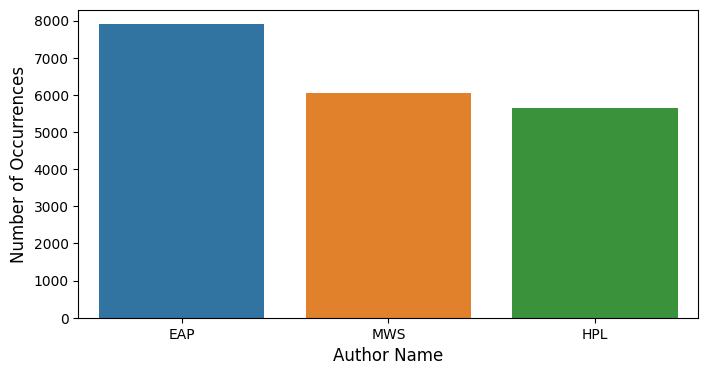

In [4]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sb.barplot(cnt_srs.index, cnt_srs.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

In [5]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
data = [go.Bar(
            x = train_df.author.map(z).unique(),
            y = train_df.author.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train_df.author.value_counts().values
                        ),
            text='Text entries attributed to Author'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [6]:
all_words = train_df['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [11]:
# ## WordClouds to visualise each author's work
# One very handy visualization tool for a data scientist when it comes to any sort of natural language processing is plotting 
# "Word Cloud". A word cloud (as the name suggests) is an image that is made up of a mixture of distinct words 
# which may make up a text or book and where the size of each word is proportional to its word frequency in 
# that text (number of times the word appears). Here instead of dealing with an actual book or text, 
# our words can simply be taken from the column "text"

# **Store the text of each author in  a Python list**

# We first create three different python lists that store the texts of Edgar Allen Poe, HP Lovecraft and Mary Shelley respectively as follows:
eap = train_df[train_df.author=="EAP"]["text"].values
hpl = train_df[train_df.author=="HPL"]["text"].values
mws = train_df[train_df.author=="MWS"]["text"].values


In [12]:
from wordcloud import WordCloud, STOPWORDS

(-0.5, 399.5, 199.5, -0.5)

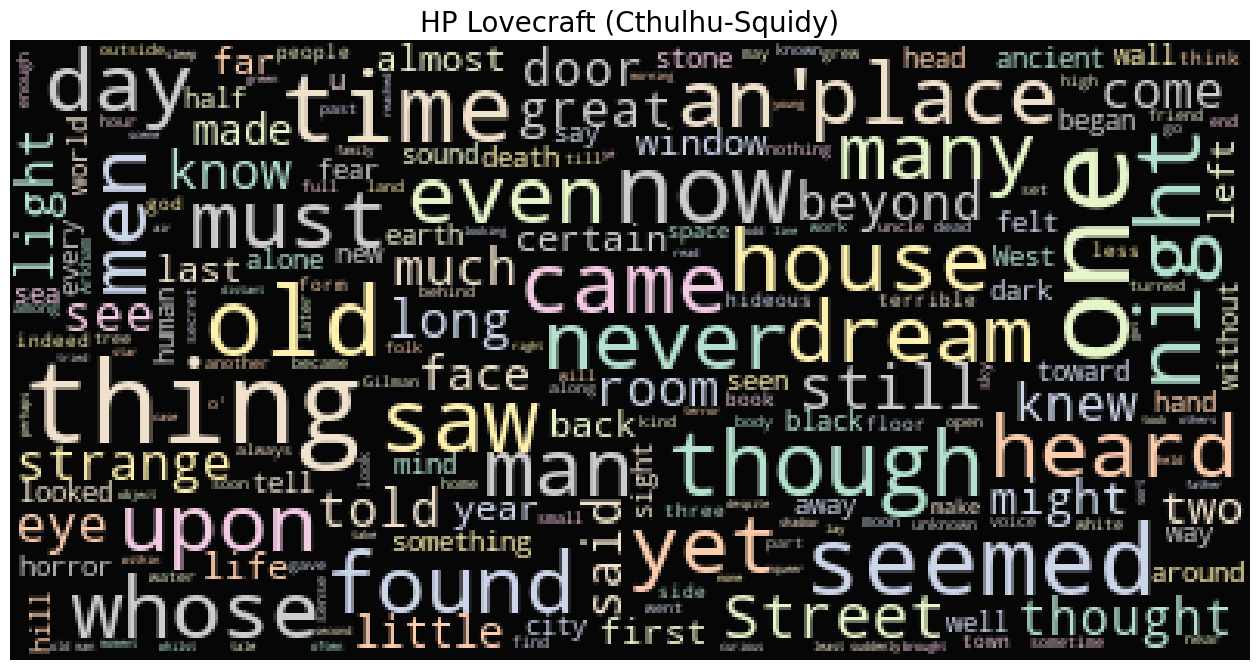

In [20]:
# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black",
               max_words=10000, 
               stopwords=STOPWORDS,
               max_font_size= 40)
wc.generate(" ".join(hpl))
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

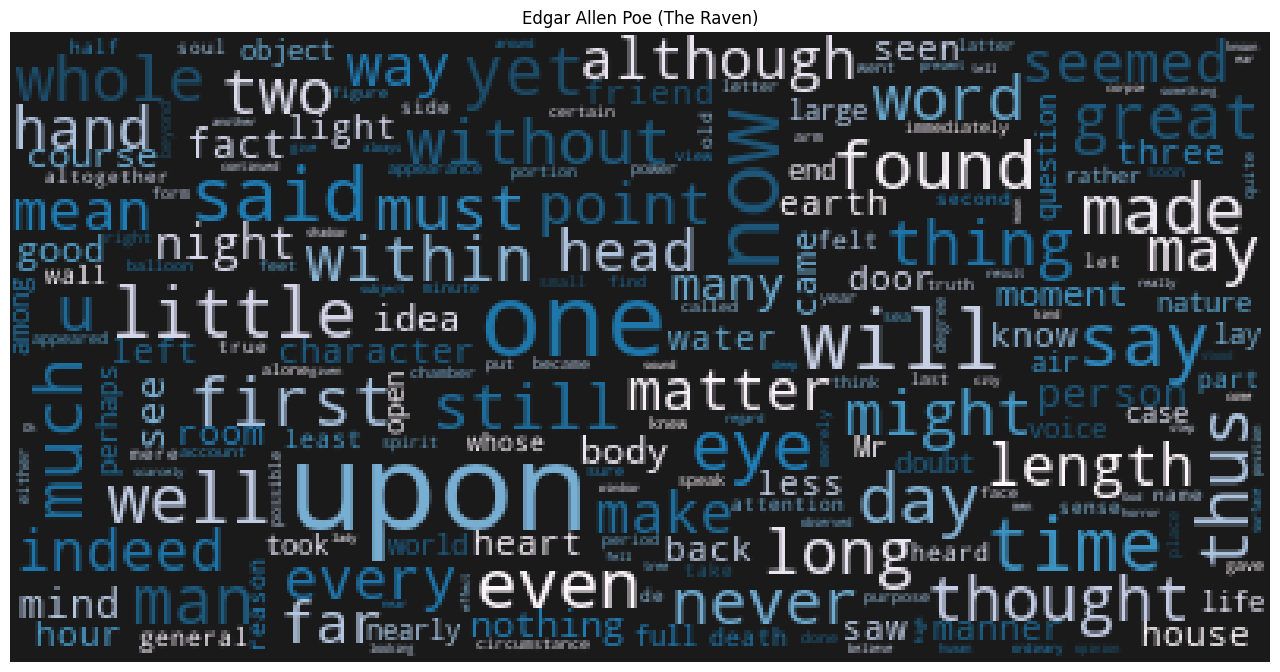

In [21]:
plt.figure(figsize=(20,18))
# The wordcloud of the raven for Edgar Allen Poe
plt.subplot(211)
wc = WordCloud(background_color="black", 
               max_words=10000, 
               stopwords=STOPWORDS, 
               max_font_size= 40)
wc.generate(" ".join(eap))
plt.title("Edgar Allen Poe (The Raven)")
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), alpha=0.9)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

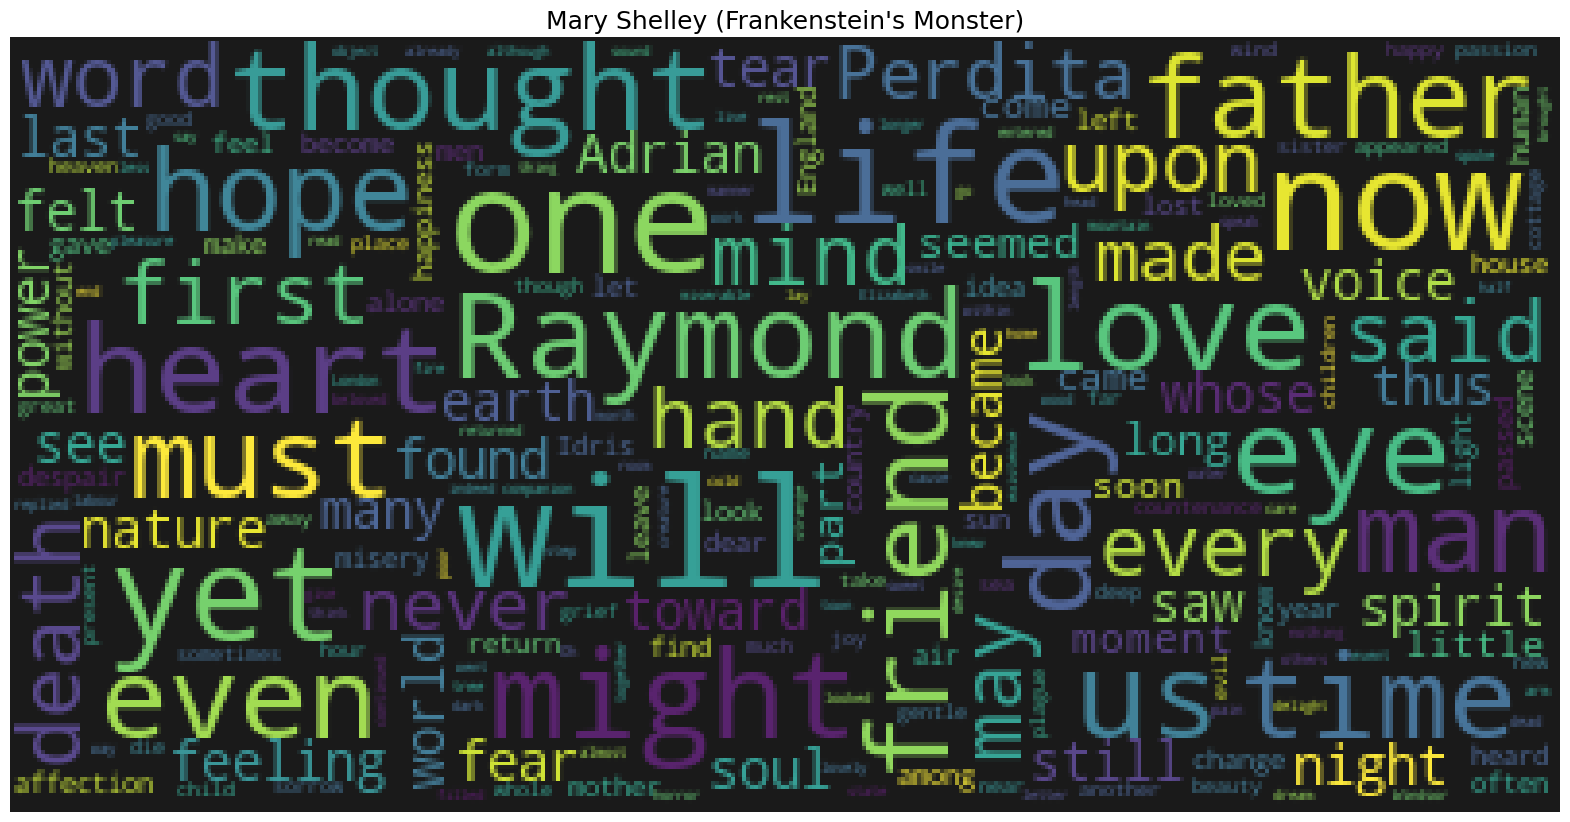

In [22]:
plt.figure(figsize=(20,18))
wc = WordCloud(background_color="black", 
               max_words=10000, 
               stopwords=STOPWORDS, 
               max_font_size= 40)
wc.generate(" ".join(mws))
plt.title("Mary Shelley (Frankenstein's Monster)", fontsize= 18)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.9)
plt.axis('off')

In [26]:
# Primer intento, 
# We will start with creating meta featues and see how good are they at predicting the spooky authors. The feature list is as follows:
## Number of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

C:\Users\U029987\Python\python-3.6.8-embed-amd64\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



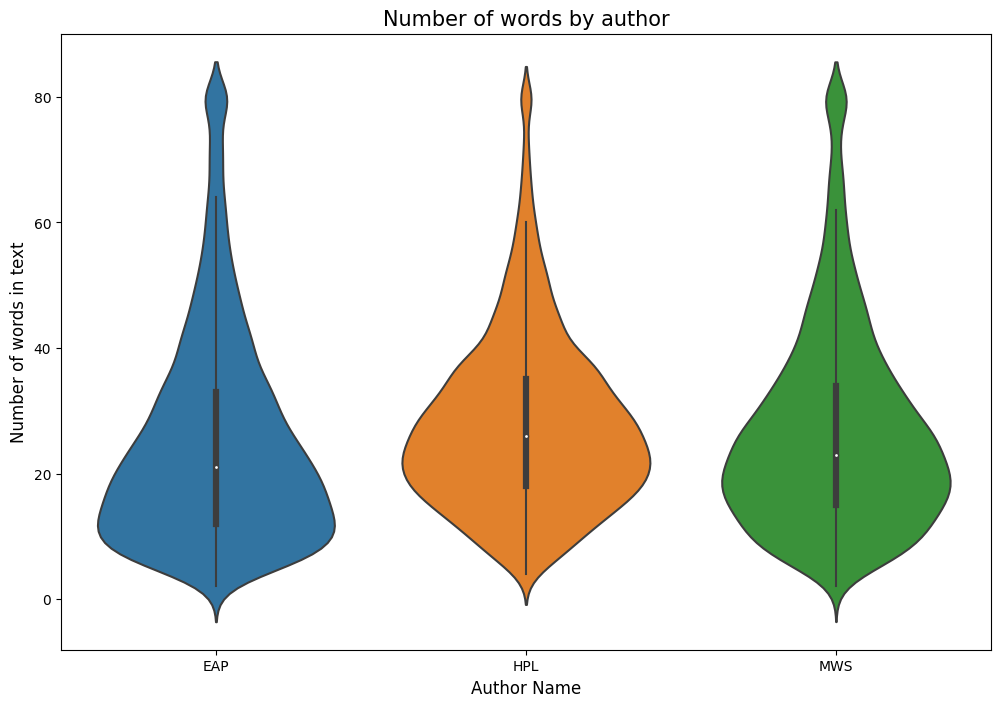

In [28]:
# Hagamos su plot
train_df['num_words'].loc[train_df['num_words']>80] = 80 #truncation for better visuals
plt.figure(figsize=(12,8))
sb.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()
# Eap tiene menos palabras

C:\Users\U029987\Python\python-3.6.8-embed-amd64\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



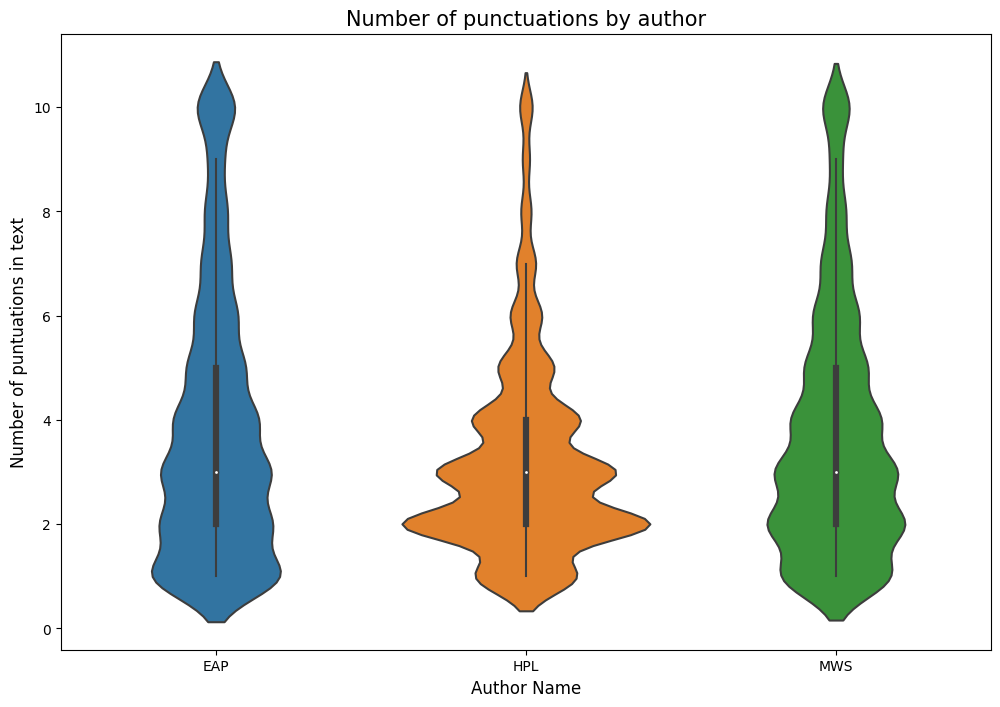

In [29]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
plt.figure(figsize=(12,8))
sb.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

In [30]:
#This also seems to be somewhat useful. Now let us focus on creating some text based features.

# Let us first build a basic model to see how these meta features are helping.

,id,text,author,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,id26305,"This process, however, afforded me no means of...",EAP,41,35,231,19,7,2,3,4.658537
1,id17569,It never once occurred to me that the fumbling...,HPL,14,14,71,8,1,0,1,4.142857
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,32,200,16,5,0,1,4.583333
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,32,206,13,4,0,4,5.088235
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,25,174,11,4,0,2,5.481481
...,...,...,...,...,...,...,...,...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP,20,19,108,11,3,2,2,4.450000
19575,id08973,The lids clenched themselves together as if in...,EAP,10,10,55,6,1,0,1,4.600000
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,13,13,68,4,2,0,2,4.307692
19577,id17513,"For an item of news like this, it strikes us i...",EAP,15,14,74,7,3,0,1,4.000000


In [60]:
## Prepare the data for modeling ###
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

### recompute the trauncated variables again ###
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [67]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
    print(model.best_ntree_limit)
    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [68]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("cv scores : ", cv_scores)

[0]	train-mlogloss:1.09384	test-mlogloss:1.09472
[20]	train-mlogloss:1.04663	test-mlogloss:1.05720
[40]	train-mlogloss:1.02368	test-mlogloss:1.03845
[60]	train-mlogloss:1.01109	test-mlogloss:1.02949
[80]	train-mlogloss:0.99824	test-mlogloss:1.01957
[100]	train-mlogloss:0.98938	test-mlogloss:1.01345
[120]	train-mlogloss:0.98209	test-mlogloss:1.00860
[140]	train-mlogloss:0.97603	test-mlogloss:1.00505
[160]	train-mlogloss:0.97088	test-mlogloss:1.00237
[180]	train-mlogloss:0.96619	test-mlogloss:1.00040
[200]	train-mlogloss:0.96141	test-mlogloss:0.99788
[220]	train-mlogloss:0.95745	test-mlogloss:0.99651
[240]	train-mlogloss:0.95372	test-mlogloss:0.99505
[260]	train-mlogloss:0.95045	test-mlogloss:0.99377
[280]	train-mlogloss:0.94730	test-mlogloss:0.99296
[300]	train-mlogloss:0.94402	test-mlogloss:0.99235
[320]	train-mlogloss:0.94112	test-mlogloss:0.99152
[340]	train-mlogloss:0.93846	test-mlogloss:0.99101
[360]	train-mlogloss:0.93540	test-mlogloss:0.99025
[380]	train-mlogloss:0.93291	test-mlo

C:\Users\U029987\Python\python-3.6.8-embed-amd64\lib\site-packages\xgboost\core.py:108: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



[20]	train-mlogloss:1.04876	test-mlogloss:1.04796
[40]	train-mlogloss:1.02533	test-mlogloss:1.02653
[60]	train-mlogloss:1.01323	test-mlogloss:1.01733
[80]	train-mlogloss:1.00110	test-mlogloss:1.00775
[100]	train-mlogloss:0.99249	test-mlogloss:1.00132
[120]	train-mlogloss:0.98486	test-mlogloss:0.99722
[140]	train-mlogloss:0.97897	test-mlogloss:0.99360
[160]	train-mlogloss:0.97367	test-mlogloss:0.99125
[180]	train-mlogloss:0.96947	test-mlogloss:0.98946
[200]	train-mlogloss:0.96483	test-mlogloss:0.98731
[220]	train-mlogloss:0.96131	test-mlogloss:0.98611
[240]	train-mlogloss:0.95771	test-mlogloss:0.98450
[260]	train-mlogloss:0.95436	test-mlogloss:0.98346
[280]	train-mlogloss:0.95106	test-mlogloss:0.98268
[300]	train-mlogloss:0.94830	test-mlogloss:0.98218
[320]	train-mlogloss:0.94554	test-mlogloss:0.98110
[340]	train-mlogloss:0.94293	test-mlogloss:0.98013
[360]	train-mlogloss:0.93952	test-mlogloss:0.97849
[380]	train-mlogloss:0.93699	test-mlogloss:0.97789
[400]	train-mlogloss:0.93437	test-m

C:\Users\U029987\Python\python-3.6.8-embed-amd64\lib\site-packages\xgboost\core.py:108: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



[20]	train-mlogloss:1.04714	test-mlogloss:1.05474
[40]	train-mlogloss:1.02363	test-mlogloss:1.03716
[60]	train-mlogloss:1.01117	test-mlogloss:1.02866
[80]	train-mlogloss:0.99792	test-mlogloss:1.01993
[100]	train-mlogloss:0.98890	test-mlogloss:1.01426
[120]	train-mlogloss:0.98118	test-mlogloss:1.00955
[140]	train-mlogloss:0.97545	test-mlogloss:1.00655
[160]	train-mlogloss:0.97025	test-mlogloss:1.00386
[180]	train-mlogloss:0.96561	test-mlogloss:1.00171
[200]	train-mlogloss:0.96090	test-mlogloss:0.99884
[220]	train-mlogloss:0.95719	test-mlogloss:0.99782
[240]	train-mlogloss:0.95373	test-mlogloss:0.99640
[260]	train-mlogloss:0.95031	test-mlogloss:0.99519
[280]	train-mlogloss:0.94728	test-mlogloss:0.99414
[300]	train-mlogloss:0.94442	test-mlogloss:0.99310
[320]	train-mlogloss:0.94166	test-mlogloss:0.99220
[340]	train-mlogloss:0.93896	test-mlogloss:0.99112
[360]	train-mlogloss:0.93576	test-mlogloss:0.99014
[380]	train-mlogloss:0.93324	test-mlogloss:0.98925
[400]	train-mlogloss:0.93071	test-m

C:\Users\U029987\Python\python-3.6.8-embed-amd64\lib\site-packages\xgboost\core.py:108: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



[20]	train-mlogloss:1.04812	test-mlogloss:1.05102
[40]	train-mlogloss:1.02545	test-mlogloss:1.03106
[60]	train-mlogloss:1.01290	test-mlogloss:1.02166
[80]	train-mlogloss:1.00002	test-mlogloss:1.01218
[100]	train-mlogloss:0.99112	test-mlogloss:1.00636
[120]	train-mlogloss:0.98367	test-mlogloss:1.00194
[140]	train-mlogloss:0.97753	test-mlogloss:0.99886
[160]	train-mlogloss:0.97226	test-mlogloss:0.99628
[180]	train-mlogloss:0.96765	test-mlogloss:0.99401
[200]	train-mlogloss:0.96298	test-mlogloss:0.99176
[220]	train-mlogloss:0.95918	test-mlogloss:0.99078
[240]	train-mlogloss:0.95581	test-mlogloss:0.98978
[260]	train-mlogloss:0.95250	test-mlogloss:0.98872
[280]	train-mlogloss:0.94920	test-mlogloss:0.98802
[300]	train-mlogloss:0.94598	test-mlogloss:0.98705
[320]	train-mlogloss:0.94338	test-mlogloss:0.98648
[340]	train-mlogloss:0.94067	test-mlogloss:0.98575
[360]	train-mlogloss:0.93746	test-mlogloss:0.98493
[380]	train-mlogloss:0.93475	test-mlogloss:0.98461
[400]	train-mlogloss:0.93214	test-m

C:\Users\U029987\Python\python-3.6.8-embed-amd64\lib\site-packages\xgboost\core.py:108: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



[20]	train-mlogloss:1.04338	test-mlogloss:1.04713
[40]	train-mlogloss:1.02354	test-mlogloss:1.03071
[60]	train-mlogloss:1.00994	test-mlogloss:1.01900
[80]	train-mlogloss:0.99964	test-mlogloss:1.01076
[100]	train-mlogloss:0.99188	test-mlogloss:1.00466
[120]	train-mlogloss:0.98583	test-mlogloss:1.00067
[140]	train-mlogloss:0.98037	test-mlogloss:0.99727
[160]	train-mlogloss:0.97488	test-mlogloss:0.99432
[180]	train-mlogloss:0.97028	test-mlogloss:0.99245
[200]	train-mlogloss:0.96598	test-mlogloss:0.99025
[220]	train-mlogloss:0.96173	test-mlogloss:0.98787
[240]	train-mlogloss:0.95814	test-mlogloss:0.98630
[260]	train-mlogloss:0.95515	test-mlogloss:0.98512
[280]	train-mlogloss:0.95160	test-mlogloss:0.98404
[300]	train-mlogloss:0.94848	test-mlogloss:0.98299
[320]	train-mlogloss:0.94538	test-mlogloss:0.98228
[340]	train-mlogloss:0.94239	test-mlogloss:0.98163
[360]	train-mlogloss:0.94030	test-mlogloss:0.98146
[380]	train-mlogloss:0.93759	test-mlogloss:0.98130
[400]	train-mlogloss:0.93495	test-m

C:\Users\U029987\Python\python-3.6.8-embed-amd64\lib\site-packages\xgboost\core.py:108: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



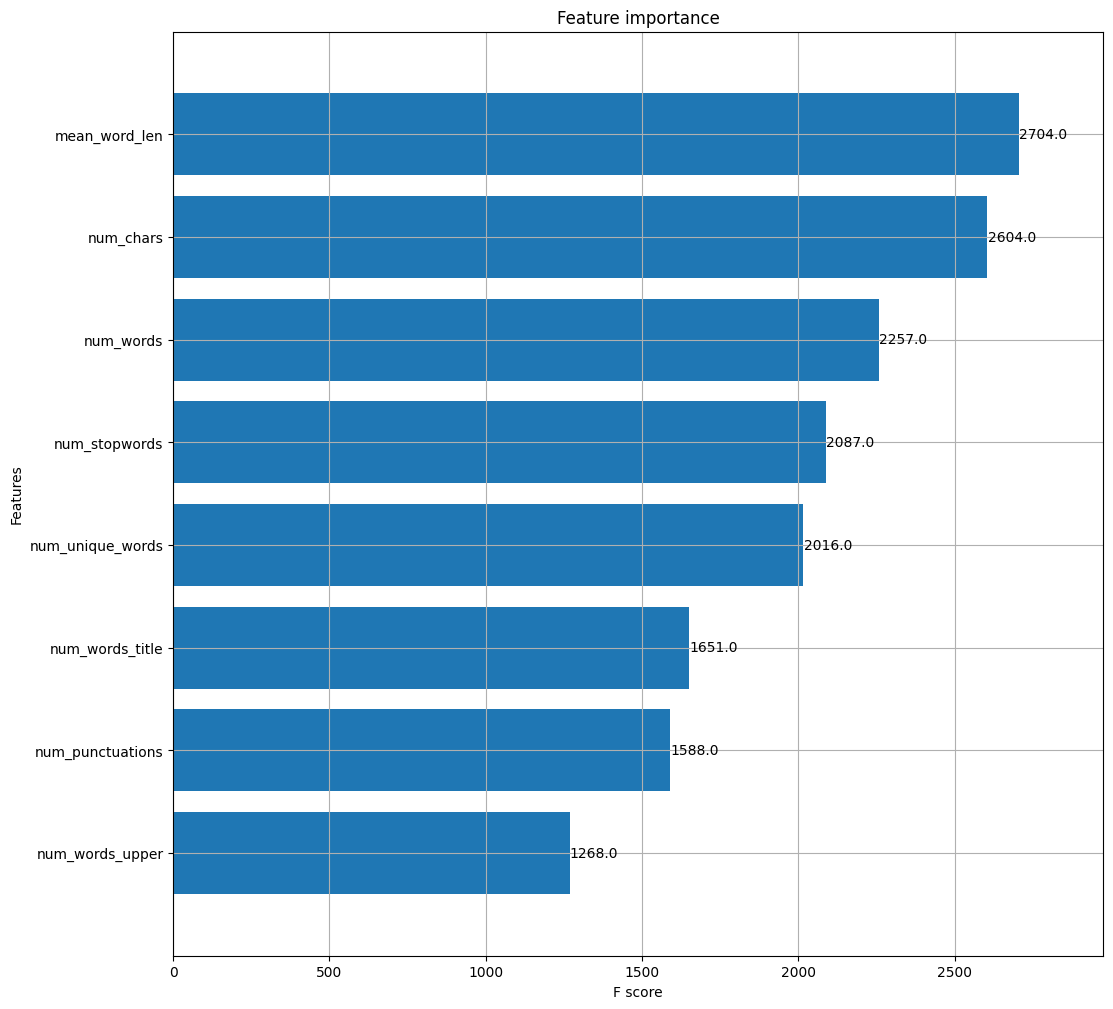

In [69]:
# We are getting a mlogloss of '0.987' using just the meta features. Not a bad score. Now let us see which of these features are important.
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

# Cambio

In [70]:
# Storing the first text element as a string
# Da errores, pues mete comas, usamos nltk
first_text = train_df.text.values[0]
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [73]:
import nltk
nltk.download('punkt')
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\U029987\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


In [75]:
# Quitamos palabras de paradsa
stopwords = nltk.corpus.stopwords.words('english')
print(len(stopwords))
first_text_list_cleaned = [word for word in first_text_list if word.lower() not in stopwords]
print(first_text_list_cleaned)
print("="*90)
print("Length of original list: {0} words\n"
      "Length of list after stopwords removal: {1} words"
      .format(len(first_text_list), len(first_text_list_cleaned)))

179
['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


In [77]:
# stemming es cambiar las variaciones d palabras. por ejemplo running, runs son lo mismo querun
stemmer = nltk.stem.PorterStemmer()
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

# tener en cuenta que a veces va mal
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run
The stemmed form of leaves is: leav


In [82]:
# usamos lematizacion
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\U029987\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\U029987\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


The lemmatized form of leaves is: leaf


In [83]:
# Defining our sentence
sentence = ["I love to eat Burgers", 
            "I love to eat Fries"]
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)
print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


In [ ]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [84]:
#  When you vectorize the raw text with CountVectorizer, the dual stages of tokenizing
#  and stopwords filtering are automatically included as a high-level component. 
#  Here unlike the NLTK tokenizer that you were introduced to in the Section 2a earlier,
#  Sklearn's tokenizer discards all single character terms like ('a', 'w' etc) 
#  and also lower cases all terms by default. Filtering out stopwords in Sklearn is
#  as convenient as passing the value 'english' into the argument "stop_words" 
#  where a built-in English stopword list is automatically used.

lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [86]:
# Storing the entire training text in a list
text = list(train_df.text.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)
tf

<19579x13781 sparse matrix of type '<class 'numpy.int64'>'
	with 212037 stored elements in Compressed Sparse Row format>

In [109]:
# Lista con todas las palabras 
feature_names = tf_vectorizer.get_feature_names()
# ['aback',
#  'abandon',
#  'abandoned'...,
count_vec = np.asarray(tf.sum(axis=0)).ravel()
# Palabras + numero veces que aparecen
zipped = list(zip(feature_names, count_vec))
# [('aback', 2),
#  ('abandon', 11),
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

In [110]:
# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='Portland',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Bottom 100 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [112]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [115]:
# encode de los datos
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train_df.author.values)

In [117]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train_df.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
print (xtrain.shape)
print (xvalid.shape)

(17621,)
(1958,)


In [120]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)


<17621x15102 sparse matrix of type '<class 'numpy.float64'>'
	with 198521 stored elements in Compressed Sparse Row format>

In [119]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.572 


C:\Users\U029987\Python\python-3.6.8-embed-amd64\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [140]:
# Forma de ver las palabras y sus probabilidades en el texto
doc = 0
feature_index = xtrain_tfv[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [xtrain_tfv[doc, x] for x in feature_index])
tfidf_scores
for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print(w, s)

summon 0.2469424385443994
renewing 0.31534173991151543
mine 0.2621357570531394
ignore 0.21913481148346806
hoof 0.2699803359499066
happens 0.28210670387497144
dominion 0.33928338965309934
devotion 0.2913532806410929
cultivating 0.3345950093082599
collate 0.3474674493892856
brick 0.3710563608683541
